In [5]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
from scipy.signal import butter, filtfilt, stft
from pathlib import Path
import re

# --- 1. CONFIGURATION (Based on your directory) ---
# We use raw string r"..." to handle backslashes in Windows paths safely
DATA_DIR = Path(r"D:\school\uni\sem 5\MLDL\TinyML UAS\src\data\st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0\files")

FS_TARGET = 128     # UCDDB sampling rate
PRE_WINDOW = 30     # Seconds BEFORE apnea to analyze
AD8232_LO = 0.5     # AD8232 Low Cutoff
AD8232_HI = 40      # AD8232 High Cutoff
MIN_EVENTS_THRESHOLD = 100 # Only plot subjects with > 100 events

# --- 2. HEADER FIXER (Crucial for UCDDB) ---
def fix_ucddb_header(original_path):
    """
    Creates a copy of the EDF with ':' replaced by '.' in the start time.
    Returns the path to the fixed file.
    """
    path_obj = Path(original_path)
    # Define the new filename
    new_path = path_obj.with_name(f"{path_obj.stem}_fixed{path_obj.suffix}")
    
    # If fixed file already exists, use it
    if new_path.exists():
        return new_path

    try:
        with open(path_obj, 'rb') as f:
            content = bytearray(f.read())
        
        # Bytes 176-184 contain start time HH:MM:SS
        start_time_chunk = content[176:184]
        
        if b':' in start_time_chunk:
            # print(f"  -> Fixing header for {path_obj.name}...")
            fixed_time_chunk = start_time_chunk.replace(b':', b'.')
            content[176:184] = fixed_time_chunk
            
            with open(new_path, 'wb') as f_out:
                f_out.write(content)
            return new_path
            
    except Exception as e:
        print(f"  -> Error fixing header: {e}")
        
    return original_path

# --- 3. FILTER SIMULATOR ---
def ad8232_filter(data, fs):
    if fs <= 0: return data
    nyq = 0.5 * fs
    # Ensure high cut is below nyquist
    hi = min(AD8232_HI, nyq - 1)
    b, a = butter(2, [AD8232_LO / nyq, hi / nyq], btype='band')
    return filtfilt(b, a, data)

# --- 4. LABEL PARSER (UPDATED & ROBUST) ---
def parse_ucddb_labels(subject_id):
    """
    Parses _respevt.txt with flexible logic.
    """
    txt_path = DATA_DIR / f"{subject_id}_respevt.txt"
    events = []
    
    # Try finding it with glob in case of case sensitivity
    if not txt_path.exists():
        candidates = list(DATA_DIR.glob(f"{subject_id}_respevt.txt"))
        if not candidates:
            return []
        txt_path = candidates[0]

    try:
        with open(txt_path, 'r') as f:
            lines = f.readlines()
    except:
        return []
    
    # Debug print for first file to see format
    if subject_id == 'ucddb002':
        print(f"\nDEBUG: First 3 lines of {subject_id}_respevt.txt:")
        for l in lines[:3]: print(f"  '{l.strip()}'")

    for line in lines:
        parts = line.strip().split()
        if not parts: continue
        
        # --- STRATEGY 1: HH:MM:SS format ---
        curr_seconds = -1
        duration = -1
        
        # Check if first token is HH:MM:SS
        if ':' in parts[0]:
            try:
                h, m, s = map(float, parts[0].split(':'))
                curr_seconds = h * 3600 + m * 60 + s
            except: pass
        
        # --- STRATEGY 2: Absolute Seconds (some files might use this) ---
        elif parts[0].replace('.', '', 1).isdigit():
             try:
                curr_seconds = float(parts[0])
             except: pass

        if curr_seconds == -1: continue

        # --- DURATION PARSING ---
        # Usually 2nd column
        if len(parts) > 1 and parts[1].replace('.', '', 1).isdigit():
            duration = float(parts[1])
        else:
            duration = 10.0 # Default fallback duration

        # --- TYPE CHECKING ---
        row_text = line.upper()
        
        is_apnea = False
        
        # Explicit Keywords
        if 'HYP' in row_text: is_apnea = True
        elif 'OBS' in row_text: is_apnea = True
        elif 'CEN' in row_text: is_apnea = True
        elif 'MIX' in row_text: is_apnea = True
        elif 'PB' in row_text: is_apnea = True
        elif 'APNEA' in row_text: is_apnea = True
        
        # Column codes (O, M, C, H)
        # We check specific columns if available to avoid false positives in comments
        if not is_apnea and len(parts) >= 3:
            code = parts[2].upper()
            if code in ['O', 'M', 'C', 'H', 'CA', 'OA', 'MA']:
                is_apnea = True
                
        if is_apnea:
            events.append({
                'start': curr_seconds,
                'duration': duration,
                'type': 'APNEA'
            })
            
    return events

# --- 5. MAIN LOOP ---
def analyze_all_subjects():
    # Find all original lifecard files
    # Note: excluding already fixed files to avoid processing twice
    edf_files = [f for f in DATA_DIR.glob("*_lifecard.edf") if "fixed" not in f.name]
    
    print(f"Found {len(edf_files)} subjects in {DATA_DIR}\n")
    
    # We will store valid subjects to plot them
    valid_subjects = []

    for i, edf_file in enumerate(edf_files):
        # Extract ID (e.g., "ucddb002")
        subject_id = edf_file.name.split('_')[0]
        
        print(f"[{i+1}/{len(edf_files)}] Processing {subject_id}...", end=" ")
        
        # 1. Fix Header
        fixed_path = fix_ucddb_header(edf_file)
        
        # 2. Load Signal
        try:
            f = pyedflib.EdfReader(str(fixed_path))
            
            # Channel selection logic: prefer ECG, else ch 0
            labels = f.getSignalLabels()
            ecg_idx = 0
            for idx, label in enumerate(labels):
                if "ECG" in label.upper() or "EKG" in label.upper():
                    ecg_idx = idx
                    break
            
            sig = f.readSignal(ecg_idx)
            fs = f.getSampleFrequency(ecg_idx)
            
            # Get Start Time
            t_start = f.getStartdatetime().time()
            rec_start_sec = t_start.hour * 3600 + t_start.minute * 60 + t_start.second
            
            f.close()
            
        except Exception as e:
            print(f"Failed to read EDF: {e}")
            continue

        # 3. Parse Labels
        events = parse_ucddb_labels(subject_id)
        
        if len(events) > MIN_EVENTS_THRESHOLD:
            print(f"SUCCESS. Found {len(events)} Apnea events (Qualified).")
            
            # --- FIND VALID PRE-APNEA SEGMENT ---
            # Loop through events until we find one that happens late enough
            # to have 30 seconds of data before it.
            
            found_valid_segment = False
            for evt in events:
                event_sec_abs = evt['start']
                
                # Handle midnight crossing logic
                if event_sec_abs < rec_start_sec: 
                    event_sec_abs += 24 * 3600
                    
                rel_start = event_sec_abs - rec_start_sec
                
                # Check if event starts after PRE_WINDOW
                if rel_start > PRE_WINDOW:
                    idx_start = int((rel_start - PRE_WINDOW) * fs)
                    idx_end = int(rel_start * fs)
                    
                    # Ensure we don't go out of bounds
                    if idx_start >= 0 and idx_end < len(sig):
                        valid_subjects.append({
                            'id': subject_id,
                            'sig': sig[idx_start:idx_end], 
                            'fs': fs,
                            'event_count': len(events)
                        })
                        found_valid_segment = True
                        break # Found one valid segment for this subject, move to next subject
            
            if not found_valid_segment:
                print("  -> Has events, but all are too early in recording.")
        else:
            print(f"Skipping (Only {len(events)} events).")

    # --- 6. PLOT ALL VALID SUBJECTS (STACKED) ---
    if not valid_subjects:
        print("\nNo valid Pre-Apnea segments found in the entire dataset.")
        return

    # Sort by event count (descending) just for interest
    valid_subjects.sort(key=lambda x: x['event_count'], reverse=True)
    
    # Use ALL valid subjects found
    num_to_plot = len(valid_subjects)
    
    print(f"\nGenerating Stacked STFT plots for ALL {num_to_plot} qualified subjects...")
    
    # Create a stacked plot (num_to_plot rows, 1 column)
    # Increase height multiplier to ensure plots aren't squished
    fig, axes = plt.subplots(num_to_plot, 1, figsize=(12, 3 * num_to_plot), sharex=True)
    
    # If only 1 plot, axes is not a list, make it a list
    if num_to_plot == 1: axes = [axes]
    
    for i in range(num_to_plot):
        subj = valid_subjects[i]
        ax = axes[i]
        
        # Filter (Simulate AD8232)
        sig_clean = ad8232_filter(subj['sig'], subj['fs'])
        
        # STFT
        # nperseg=256 gives good time resolution for short windows
        f, t, Zxx = stft(sig_clean, subj['fs'], nperseg=256)
        
        # Plot
        # Use pcolormesh for heatmap
        im = ax.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='magma')
        
        ax.set_title(f"Subject {subj['id']} (Total Events: {subj['event_count']})")
        ax.set_ylim(0, 40) # AD8232 Limit
        ax.set_ylabel('Freq (Hz)')
        
        # Add colorbar for each to see intensity
        fig.colorbar(im, ax=ax, label='Magnitude')

    axes[-1].set_xlabel('Time (s) before Apnea')
    plt.tight_layout()
    plt.show()

# Run the master loop
analyze_all_subjects()

Found 25 subjects in D:\school\uni\sem 5\MLDL\TinyML UAS\src\data\st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0\files

[1/25] Processing ucddb002... 
DEBUG: First 3 lines of ucddb002_respevt.txt:
  'Respiratory Event List'
  'Respiratory Event           Desaturation   Snore Arousal     B/T'
  'Time       Type   PB/CS  Duration  Low    %Drop                 Rate  Change'
SUCCESS. Found 124 Apnea events (Qualified).
  -> Has events, but all are too early in recording.
[2/25] Processing ucddb003... SUCCESS. Found 305 Apnea events (Qualified).
  -> Has events, but all are too early in recording.
[3/25] Processing ucddb005... Skipping (Only 57 events).
[4/25] Processing ucddb006... SUCCESS. Found 222 Apnea events (Qualified).
  -> Has events, but all are too early in recording.
[5/25] Processing ucddb007... Skipping (Only 73 events).
[6/25] Processing ucddb008... Skipping (Only 19 events).
[7/25] Processing ucddb009... Skipping (Only 76 events).
[8/25]

PRE-APNEA EDA - Using Polysomnography .rec Files
These contain ECG synchronized with apnea labels!
Hardware Target: AD8232 ECG Sensor | Platform: ESP32

Found 25 polysomnography recordings

[1/25] Processing ucddb002... Channels: ['Lefteye', 'RightEye', 'EMG', 'C3A2', 'C4A1']... Using 'ECG' | 115 events | ✓ Extracted 115 events!
[2/25] Processing ucddb003... Channels: ['Lefteye', 'RightEye', 'EMG', 'C3A2', 'C4A1']... Using 'ECG' | 268 events | ✓ Extracted 268 events!
[3/25] Processing ucddb005... Channels: ['Lefteye', 'RightEye', 'EMG', 'C3A2', 'C4A1']... Using 'ECG' | 55 events | ✓ Extracted 55 events!
[4/25] Processing ucddb006... Channels: ['Lefteye', 'RightEye', 'EMG', 'C3A2', 'C4A1']... Using 'ECG' | 127 events | ✓ Extracted 127 events!
[5/25] Processing ucddb007... Channels: ['Lefteye', 'RightEye', 'EMG', 'C3A2', 'C4A1']... Using 'ECG' | 54 events | ✓ Extracted 54 events!
[6/25] Processing ucddb008... Channels: ['Lefteye', 'RightEye', 'EMG', 'C3A2', 'C4A1']... Using 'ECG' | 18 ev

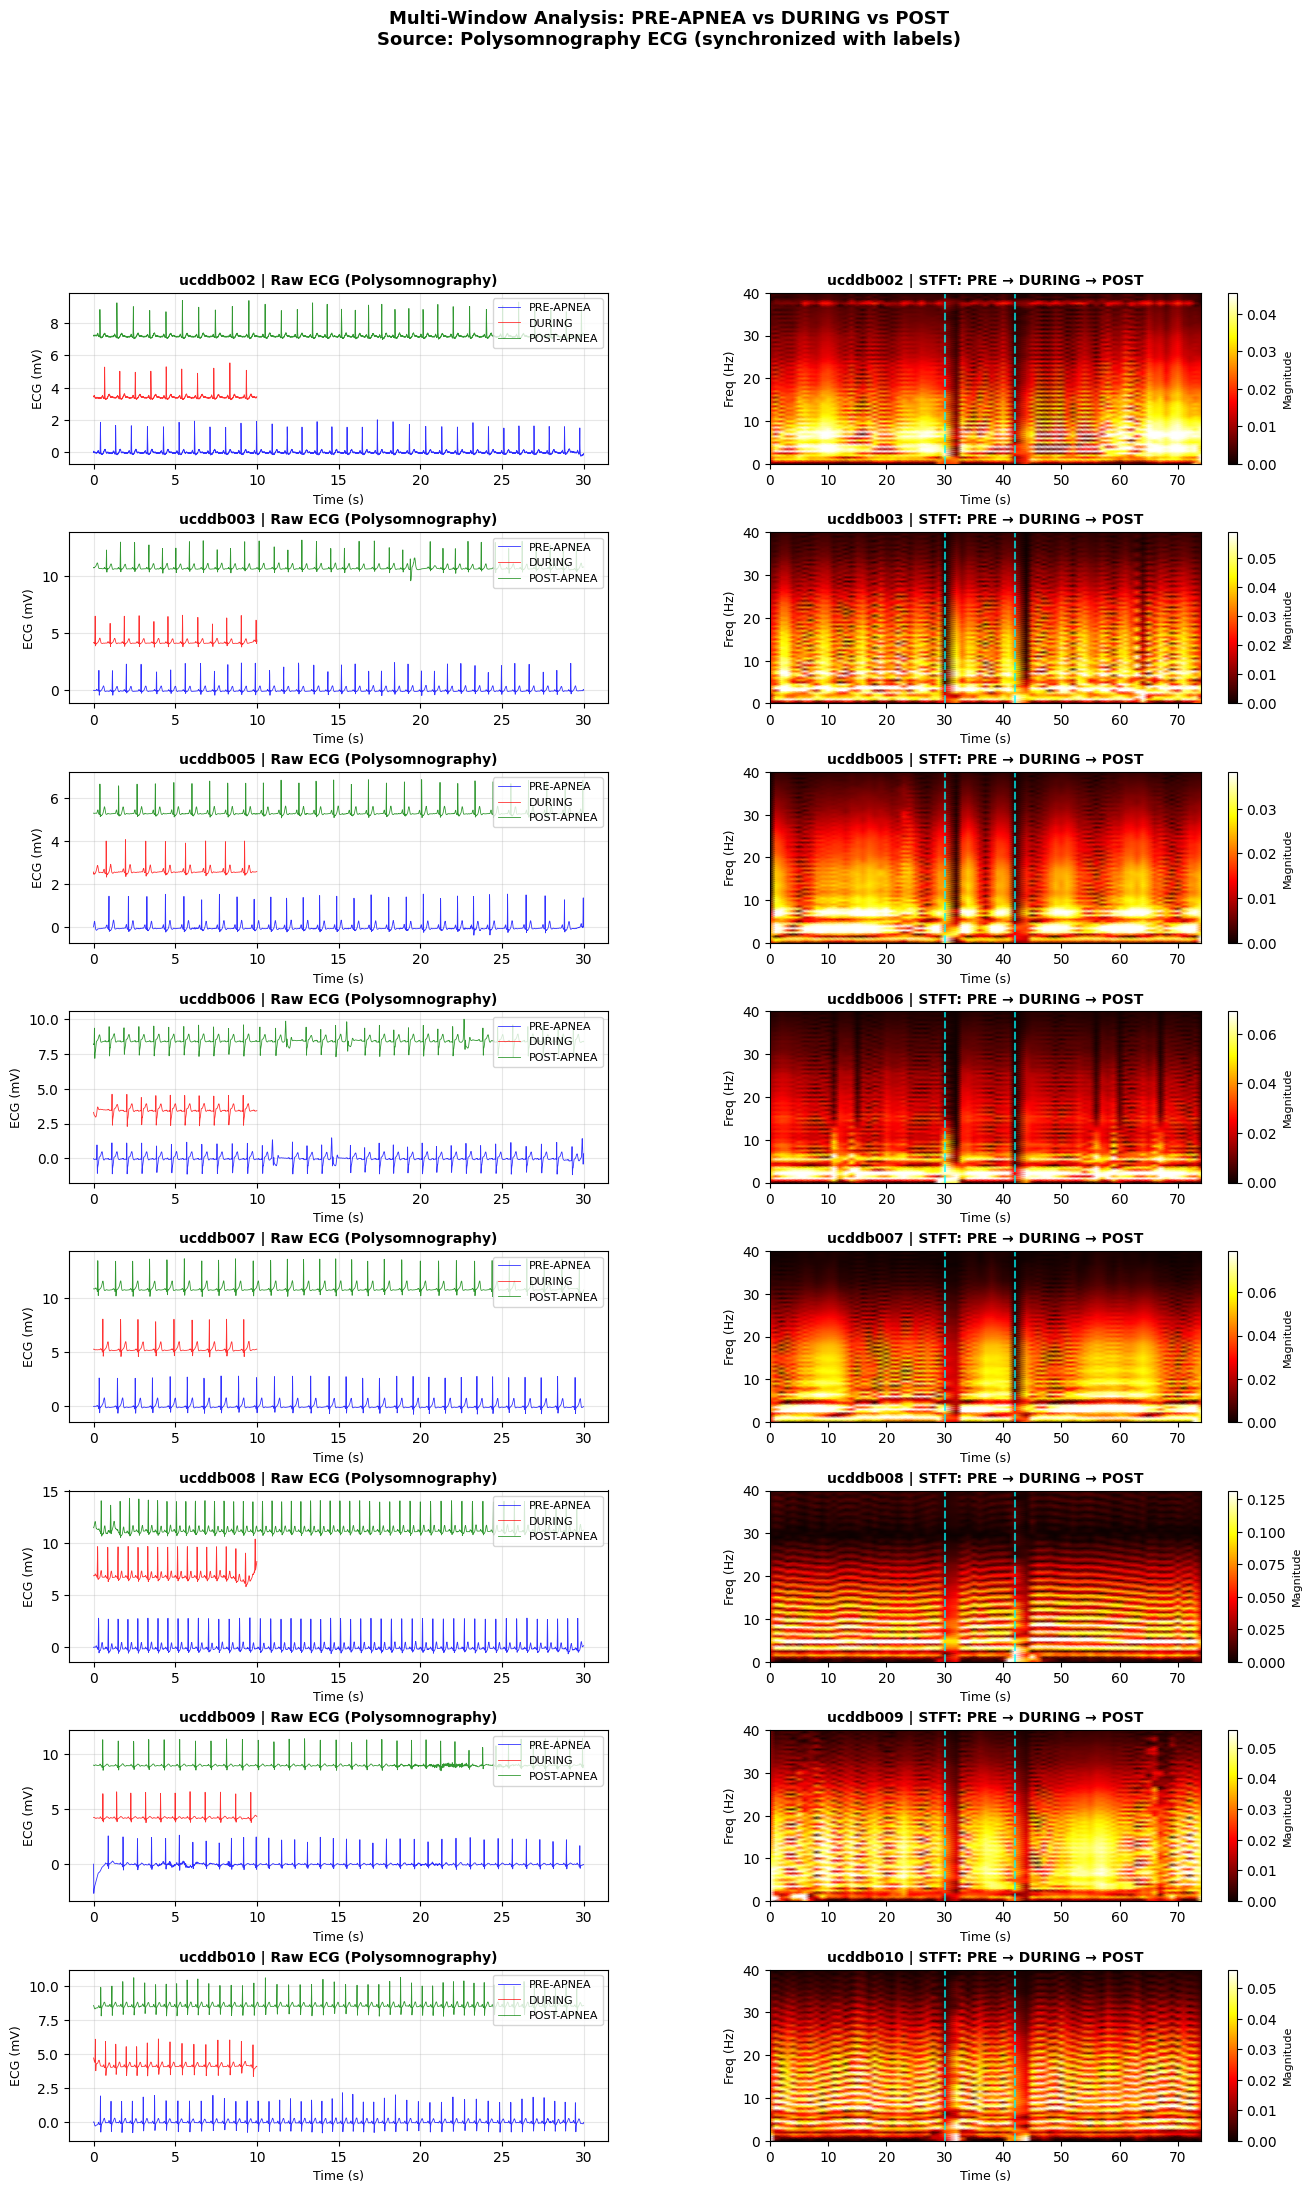

In [11]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
from scipy.signal import butter, filtfilt, stft, welch, find_peaks, resample
from scipy.stats import kurtosis, skew
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION
# =============================================================================
DATA_DIR = Path(r"D:\school\uni\sem 5\MLDL\TinyML UAS\src\data\st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0\files")

FS_TARGET = 128         # Target sampling rate (will resample if needed)
PRE_WINDOW = 30         # Seconds BEFORE apnea to analyze
DURING_WINDOW = 10      # Seconds DURING apnea
POST_WINDOW = 30        # Seconds AFTER apnea

AD8232_LO = 0.5         # AD8232 Low Cutoff (Hz)
AD8232_HI = 40          # AD8232 High Cutoff (Hz)
MIN_EVENTS_THRESHOLD = 10

WINDOW_CONFIGS = [
    {'name': 'PRE-APNEA (30s before)', 'offset': -30, 'duration': 30},
    {'name': 'DURING APNEA', 'offset': 0, 'duration': 10},
    {'name': 'POST-APNEA (30s after)', 'offset': 10, 'duration': 30},
]

# =============================================================================
# HEADER FIXER
# =============================================================================
def fix_ucddb_header(original_path):
    """Fix UCDDB EDF header time format issue"""
    path_obj = Path(original_path)
    new_path = path_obj.with_name(f"{path_obj.stem}_fixed{path_obj.suffix}")
    
    if new_path.exists():
        return new_path

    try:
        with open(path_obj, 'rb') as f:
            content = bytearray(f.read())
        
        start_time_chunk = content[176:184]
        
        if b':' in start_time_chunk:
            fixed_time_chunk = start_time_chunk.replace(b':', b'.')
            content[176:184] = fixed_time_chunk
            
            with open(new_path, 'wb') as f_out:
                f_out.write(content)
            return new_path
            
    except Exception as e:
        print(f"  -> Error fixing header: {e}")
        
    return original_path

# =============================================================================
# AD8232 FILTER SIMULATOR
# =============================================================================
def ad8232_filter(data, fs):
    """Simulate AD8232 bandpass filter (0.5-40 Hz)"""
    if fs <= 0 or len(data) < 10: 
        return data
    
    nyq = 0.5 * fs
    hi = min(AD8232_HI, nyq - 1)
    
    b, a = butter(2, [AD8232_LO / nyq, hi / nyq], btype='band')
    return filtfilt(b, a, data)

# =============================================================================
# LABEL PARSER
# =============================================================================
def parse_ucddb_labels(subject_id):
    """Parse _respevt.txt - returns events with time in seconds from midnight"""
    txt_path = DATA_DIR / f"{subject_id}_respevt.txt"
    events = []
    
    if not txt_path.exists():
        candidates = list(DATA_DIR.glob(f"{subject_id}_respevt.txt"))
        if not candidates:
            return []
        txt_path = candidates[0]

    try:
        with open(txt_path, 'r') as f:
            lines = f.readlines()
    except:
        return []

    for line in lines:
        parts = line.strip().split()
        if not parts: 
            continue
        
        curr_seconds = -1
        duration = 10.0
        
        if ':' in parts[0]:
            try:
                h, m, s = map(float, parts[0].split(':'))
                curr_seconds = h * 3600 + m * 60 + s
            except: 
                pass
        elif parts[0].replace('.', '', 1).isdigit():
            try:
                curr_seconds = float(parts[0])
            except: 
                pass

        if curr_seconds == -1: 
            continue

        if len(parts) > 1 and parts[1].replace('.', '', 1).isdigit():
            duration = float(parts[1])

        row_text = line.upper()
        event_type = None
        
        if 'HYP' in row_text: 
            event_type = 'HYPOPNEA'
        elif 'OBS' in row_text or (len(parts) >= 3 and parts[2].upper() == 'O'): 
            event_type = 'OBSTRUCTIVE'
        elif 'CEN' in row_text or (len(parts) >= 3 and parts[2].upper() == 'C'): 
            event_type = 'CENTRAL'
        elif 'MIX' in row_text or (len(parts) >= 3 and parts[2].upper() == 'M'): 
            event_type = 'MIXED'
        
        if event_type:
            events.append({
                'start': curr_seconds,
                'duration': duration,
                'type': event_type
            })
            
    return events

# =============================================================================
# FEATURE EXTRACTION
# =============================================================================
def extract_time_domain_features(signal, fs):
    features = {}
    
    if len(signal) < 10:
        return {k: 0 for k in ['mean', 'std', 'var', 'max', 'min', 'range', 
                               'skewness', 'kurtosis', 'zero_crossing_rate',
                               'num_peaks', 'mean_rr', 'std_rr', 'rmssd', 'heart_rate_est']}
    
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['var'] = np.var(signal)
    features['max'] = np.max(signal)
    features['min'] = np.min(signal)
    features['range'] = features['max'] - features['min']
    features['skewness'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)
    
    zero_crossings = np.sum(np.diff(np.sign(signal)) != 0)
    features['zero_crossing_rate'] = zero_crossings / len(signal)
    
    height_threshold = np.mean(signal) + 0.5 * np.std(signal)
    peaks, _ = find_peaks(signal, height=height_threshold, distance=int(0.4*fs))
    
    features['num_peaks'] = len(peaks)
    
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs
        features['mean_rr'] = np.mean(rr_intervals)
        features['std_rr'] = np.std(rr_intervals)
        features['rmssd'] = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
        features['heart_rate_est'] = 60.0 / features['mean_rr'] if features['mean_rr'] > 0 else 0
    else:
        features['mean_rr'] = 0
        features['std_rr'] = 0
        features['rmssd'] = 0
        features['heart_rate_est'] = 0
    
    return features

def extract_frequency_domain_features(signal, fs):
    features = {}
    
    if len(signal) < 256:
        return {k: 0 for k in ['lf_power', 'hf_power', 'lf_hf_ratio', 
                               'total_power', 'spectral_entropy', 'dominant_freq']}
    
    nperseg = min(256, len(signal))
    freqs, psd = welch(signal, fs, nperseg=nperseg)
    
    lf_band = (freqs >= 0.04) & (freqs <= 0.15)
    hf_band = (freqs >= 0.15) & (freqs <= 0.4)
    
    features['lf_power'] = np.trapz(psd[lf_band], freqs[lf_band]) if np.any(lf_band) else 0
    features['hf_power'] = np.trapz(psd[hf_band], freqs[hf_band]) if np.any(hf_band) else 0
    features['lf_hf_ratio'] = features['lf_power'] / features['hf_power'] if features['hf_power'] > 0 else 0
    
    features['total_power'] = np.trapz(psd, freqs)
    
    psd_norm = psd / (np.sum(psd) + 1e-12)
    features['spectral_entropy'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))
    
    features['dominant_freq'] = freqs[np.argmax(psd)]
    
    return features

def extract_stft_features(signal, fs):
    features = {}
    
    if len(signal) < 256:
        return {k: 0 for k in ['stft_mean', 'stft_std', 'stft_max', 
                               'spectral_flux_mean', 'spectral_flux_std',
                               'spectral_centroid_mean', 'spectral_centroid_std']}, None
    
    nperseg = min(256, len(signal) // 4)
    f, t, Zxx = stft(signal, fs, nperseg=nperseg)
    magnitude = np.abs(Zxx)
    
    freq_mask = (f >= 0.5) & (f <= 40)
    if np.any(freq_mask):
        magnitude = magnitude[freq_mask, :]
        f = f[freq_mask]
    
    features['stft_mean'] = np.mean(magnitude)
    features['stft_std'] = np.std(magnitude)
    features['stft_max'] = np.max(magnitude)
    
    if magnitude.shape[1] > 1:
        spectral_flux = np.sqrt(np.sum(np.diff(magnitude, axis=1)**2, axis=0))
        features['spectral_flux_mean'] = np.mean(spectral_flux)
        features['spectral_flux_std'] = np.std(spectral_flux)
        
        spectral_centroid = np.sum(f.reshape(-1, 1) * magnitude, axis=0) / (np.sum(magnitude, axis=0) + 1e-12)
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        features['spectral_centroid_std'] = np.std(spectral_centroid)
    else:
        features['spectral_flux_mean'] = 0
        features['spectral_flux_std'] = 0
        features['spectral_centroid_mean'] = 0
        features['spectral_centroid_std'] = 0
    
    return features, (f, t, Zxx)

# =============================================================================
# MAIN EDA USING .REC FILES (Polysomnography recordings)
# =============================================================================
def eda_using_rec_files():
    """
    Use the .rec files (polysomnography) which have synchronized ECG and labels!
    """
    
    print("="*80)
    print("PRE-APNEA EDA - Using Polysomnography .rec Files")
    print("These contain ECG synchronized with apnea labels!")
    print("Hardware Target: AD8232 ECG Sensor | Platform: ESP32")
    print("="*80)
    print()
    
    # Find .rec files instead of _lifecard.edf
    rec_files = list(DATA_DIR.glob("ucddb*.rec"))
    
    # If no .rec files found, try with .edf extension
    if len(rec_files) == 0:
        rec_files = [f for f in DATA_DIR.glob("ucddb*.edf") if "lifecard" not in f.name.lower() and "fixed" not in f.name.lower()]
    
    print(f"Found {len(rec_files)} polysomnography recordings\n")
    
    if len(rec_files) == 0:
        print("ERROR: No .rec or polysomnography .edf files found!")
        print("Expected files like: ucddb002.rec or ucddb002.edf")
        print(f"\nFiles in directory: {list(DATA_DIR.glob('ucddb*'))[:10]}")
        return
    
    subjects_with_all_windows = []
    all_features = []
    
    for i, rec_file in enumerate(rec_files):
        # Extract subject ID (e.g., ucddb002)
        subject_id = rec_file.stem.split('_')[0]
        
        print(f"[{i+1}/{len(rec_files)}] Processing {subject_id}... ", end="")
        
        # Fix header if needed
        fixed_path = fix_ucddb_header(rec_file)
        
        # Load polysomnography recording
        try:
            f = pyedflib.EdfReader(str(fixed_path))
            
            # Find ECG channel
            labels = f.getSignalLabels()
            ecg_idx = None
            
            print(f"Channels: {labels[:5]}... ", end="")
            
            for idx, label in enumerate(labels):
                label_upper = label.upper()
                if "ECG" in label_upper or "EKG" in label_upper:
                    ecg_idx = idx
                    print(f"Using '{label}' | ", end="")
                    break
            
            if ecg_idx is None:
                print("No ECG channel found!")
                f.close()
                continue
            
            # Read ECG signal
            sig = f.readSignal(ecg_idx)
            fs = f.getSampleFrequency(ecg_idx)
            
            # Get recording start time
            t_start = f.getStartdatetime()
            rec_start_sec = t_start.hour * 3600 + t_start.minute * 60 + t_start.second
            
            recording_duration = len(sig) / fs
            
            f.close()
            
            # Resample to target FS if needed (for consistency)
            if fs != FS_TARGET:
                num_samples = int(len(sig) * FS_TARGET / fs)
                sig = resample(sig, num_samples)
                fs = FS_TARGET
                print(f"Resampled to {FS_TARGET}Hz | ", end="")
            
        except Exception as e:
            print(f"Failed to read: {e}")
            continue
        
        # Parse labels
        events = parse_ucddb_labels(subject_id)
        
        if len(events) < MIN_EVENTS_THRESHOLD:
            print(f"Only {len(events)} events")
            continue
        
        event_types = [e['type'] for e in events]
        type_counts = pd.Series(event_types).value_counts()
        
        print(f"{len(events)} events | ", end="")
        
        # Now extract windows - events should be in RELATIVE time (seconds from start)
        # We need to convert event timestamps to relative position in recording
        
        windows_extracted = {}
        extracted_count = 0
        
        for evt in events:
            event_sec_abs = evt['start']
            
            # Handle midnight crossing
            if event_sec_abs < rec_start_sec:
                event_sec_abs += 24 * 3600
            
            rel_start = event_sec_abs - rec_start_sec
            
            # Check if event is within recording
            if rel_start < 0 or rel_start > recording_duration:
                continue
            
            # Try to extract all windows
            can_extract_all = True
            temp_windows = {}
            
            for config in WINDOW_CONFIGS:
                window_start_time = rel_start + config['offset']
                window_end_time = window_start_time + config['duration']
                
                if window_start_time < 0 or window_end_time > recording_duration:
                    can_extract_all = False
                    break
                
                idx_start = int(window_start_time * fs)
                idx_end = int(window_end_time * fs)
                
                if idx_start < 0 or idx_end >= len(sig):
                    can_extract_all = False
                    break
                
                segment = sig[idx_start:idx_end]
                segment_filtered = ad8232_filter(segment, fs)
                
                temp_windows[config['name']] = {
                    'signal': segment_filtered,
                    'raw_signal': segment,
                    'time_offset': window_start_time
                }
            
            if can_extract_all:
                extracted_count += 1
                
                # Store only first valid event for visualization
                if not windows_extracted:
                    windows_extracted = temp_windows
                    
                    subjects_with_all_windows.append({
                        'id': subject_id,
                        'fs': fs,
                        'windows': windows_extracted,
                        'event_type': evt['type'],
                        'event_duration': evt['duration'],
                        'total_events': len(events),
                        'event_types': type_counts.to_dict()
                    })
                
                # Extract features for ALL valid events
                for window_name, window_data in temp_windows.items():
                    time_feat = extract_time_domain_features(window_data['signal'], fs)
                    freq_feat = extract_frequency_domain_features(window_data['signal'], fs)
                    stft_feat, _ = extract_stft_features(window_data['signal'], fs)
                    
                    combined_features = {
                        'subject_id': subject_id,
                        'window_type': window_name,
                        'event_type': evt['type'],
                        **time_feat,
                        **freq_feat,
                        **stft_feat
                    }
                    
                    all_features.append(combined_features)
        
        if extracted_count > 0:
            print(f"✓ Extracted {extracted_count} events!")
        else:
            print(f"⚠️ No events within recording bounds")
    
    print(f"\n{'='*80}")
    print(f"SUCCESS! Subjects with valid data: {len(subjects_with_all_windows)}")
    print(f"Total feature vectors: {len(all_features)}")
    print(f"{'='*80}\n")
    
    if len(subjects_with_all_windows) == 0:
        print("ERROR: Still no valid data!")
        print("\nPossible issues:")
        print("1. .rec files might not exist in this directory")
        print("2. Time synchronization still problematic")
        print("\nTry checking what files you actually have:")
        all_files = list(DATA_DIR.glob("ucddb*"))
        for f in all_files[:20]:
            print(f"  - {f.name}")
        return
    
    df_features = pd.DataFrame(all_features)
    
    # ==========================================================================
    # VISUALIZATION
    # ==========================================================================
    num_subjects = min(8, len(subjects_with_all_windows))
    
    print(f"Generating visualizations for {num_subjects} subjects...\n")
    
    fig = plt.figure(figsize=(16, 3*num_subjects))
    
    for i in range(num_subjects):
        subj = subjects_with_all_windows[i]
        
        gs = fig.add_gridspec(num_subjects, 2, hspace=0.4, wspace=0.3)
        
        # LEFT: Raw ECG
        ax_ecg = fig.add_subplot(gs[i, 0])
        
        colors = ['blue', 'red', 'green']
        labels_list = ['PRE-APNEA', 'DURING', 'POST-APNEA']
        
        for j, (window_name, color, label) in enumerate(zip(
            ['PRE-APNEA (30s before)', 'DURING APNEA', 'POST-APNEA (30s after)'],
            colors, labels_list)):
            
            window_data = subj['windows'][window_name]
            sig = window_data['signal']
            time_vec = np.arange(len(sig)) / subj['fs']
            
            offset = j * (np.max(sig) - np.min(sig)) * 1.5
            ax_ecg.plot(time_vec, sig + offset, color=color, linewidth=0.6, 
                       alpha=0.8, label=label)
        
        ax_ecg.set_ylabel('ECG (mV)', fontsize=9)
        ax_ecg.set_xlabel('Time (s)', fontsize=9)
        ax_ecg.legend(loc='upper right', fontsize=8)
        ax_ecg.grid(True, alpha=0.3)
        ax_ecg.set_title(f"{subj['id']} | Raw ECG (Polysomnography)", 
                        fontsize=10, fontweight='bold')
        
        # RIGHT: STFT
        ax_stft = fig.add_subplot(gs[i, 1])
        
        all_stfts = []
        all_times = []
        f_common = None
        
        for window_name in ['PRE-APNEA (30s before)', 'DURING APNEA', 'POST-APNEA (30s after)']:
            window_data = subj['windows'][window_name]
            sig = window_data['signal']
            
            nperseg = min(256, len(sig) // 4)
            f, t, Zxx = stft(sig, subj['fs'], nperseg=nperseg)
            
            if f_common is None:
                f_common = f
            
            all_stfts.append(np.abs(Zxx))
            all_times.append(t)
        
        combined_stft = np.concatenate(all_stfts, axis=1)
        
        gap = 2
        time_axis = []
        current_time = 0
        for t_arr in all_times:
            time_axis.extend(t_arr + current_time)
            current_time += t_arr[-1] + gap
        
        time_axis = np.array(time_axis)
        
        im = ax_stft.pcolormesh(time_axis, f_common, combined_stft, 
                                shading='gouraud', cmap='hot',
                                vmin=0, vmax=np.percentile(combined_stft, 98))
        
        ax_stft.set_ylim(0, 40)
        ax_stft.set_ylabel('Freq (Hz)', fontsize=9)
        ax_stft.set_xlabel('Time (s)', fontsize=9)
        ax_stft.set_title(f"{subj['id']} | STFT: PRE → DURING → POST", 
                         fontsize=10, fontweight='bold')
        
        sep1 = all_times[0][-1]
        sep2 = sep1 + gap + all_times[1][-1]
        ax_stft.axvline(x=sep1, color='cyan', linestyle='--', linewidth=1.5, alpha=0.7)
        ax_stft.axvline(x=sep2, color='cyan', linestyle='--', linewidth=1.5, alpha=0.7)
        
        cbar = plt.colorbar(im, ax=ax_stft)
        cbar.set_label('Magnitude', fontsize=8)
    
    fig.suptitle('Multi-Window Analysis: PRE-APNEA vs DURING vs POST\n' + 
                 'Source: Polysomnography ECG (synchronized with labels)',
                 fontsize=13, fontweight='bold', y=0.998)
    
    plt.tight_layout()
    
    # ==========================================================================
    # FEATURE STATISTICS
    # ==========================================================================
    print("\n" + "="*80)
    print("FEATURE COMPARISON - PRE vs DURING vs POST")
    print("="*80)
    
    for window_type in ['PRE-APNEA (30s before)', 'DURING APNEA', 'POST-APNEA (30s after)']:
        subset = df_features[df_features['window_type'] == window_type]
        if len(subset) > 0:
            print(f"\n{window_type} (n={len(subset)}):")
            print(f"  Heart Rate:    {subset['heart_rate_est'].mean():6.1f} ± {subset['heart_rate_est'].std():5.1f} bpm")
            print(f"  RMSSD (HRV):   {subset['rmssd'].mean():6.4f} ± {subset['rmssd'].std():6.4f}")
            print(f"  LF/HF Ratio:   {subset['lf_hf_ratio'].mean():6.3f} ± {subset['lf_hf_ratio'].std():6.3f}")
            print(f"  Spectral Flux: {subset['spectral_flux_mean'].mean():6.2f} ± {subset['spectral_flux_mean'].std():6.2f}")
    
    output_csv = DATA_DIR / "pre_apnea_features_FROM_REC.csv"
    df_features.to_csv(output_csv, index=False)
    print(f"\n✓ Features saved to: {output_csv}")
    
    print("\n" + "="*80)
    print("TinyML INSIGHTS - AD8232 + ESP32")
    print("="*80)
    print(f"""
    ✓ Successfully analyzed {len(subjects_with_all_windows)} subjects
    ✓ Total samples: {len(all_features)} feature vectors
    
    EXAMINE THE PLOTS:
    1. Raw ECG (left): Look for amplitude/rhythm changes PRE vs DURING
    2. STFT (right): Look for frequency shifts as apnea approaches
    
    KEY FEATURES FOR ESP32 IMPLEMENTATION:
    - Heart rate variability metrics (RMSSD, std_rr)
    - LF/HF ratio (indicates autonomic nervous system changes)
    - Spectral flux (rate of spectrum change)
    - Zero crossing rate
    
    These features can be computed in real-time on ESP32!
    """)
    
    plt.show()

if __name__ == "__main__":
    eda_using_rec_files()


FEATURE DISCRIMINATION ANALYSIS

Which features best separate PRE-APNEA from DURING APNEA?

Feature                  | PRE-APNEA Mean | DURING Mean | % Difference
--------------------------------------------------------------------------------
heart_rate_est            |       69.3620 |     67.4105 |         2.8%
rmssd                     |        0.0528 |      0.0524 |         0.6%
lf_hf_ratio               |        0.0000 |      0.0000 |         0.0%
spectral_flux_mean        |        0.0758 |      0.0794 |         4.7%
zero_crossing_rate        |        0.0575 |      0.0548 |         4.7%
spectral_entropy          |        5.5728 |      5.5509 |         0.4%
std_rr                    |        0.0609 |      0.0490 |        19.6%


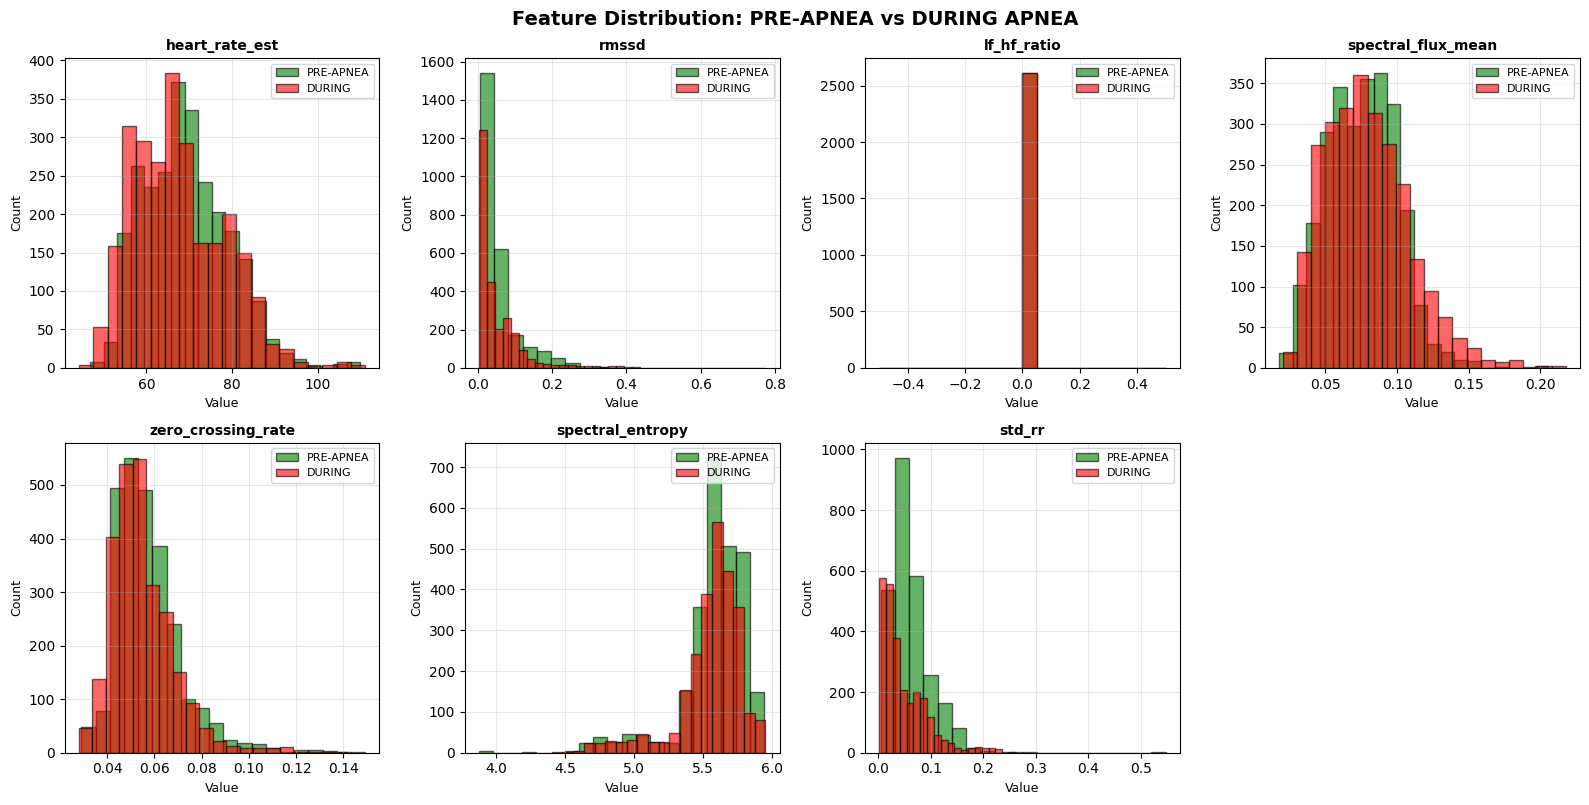

In [13]:
# Add this at the end of your script or in a new cell
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the saved features
df = pd.read_csv(DATA_DIR / "pre_apnea_features_FROM_REC.csv")

# Compare PRE vs DURING
pre_data = df[df['window_type'] == 'PRE-APNEA (30s before)']
during_data = df[df['window_type'] == 'DURING APNEA']

# Calculate feature differences
key_features = ['heart_rate_est', 'rmssd', 'lf_hf_ratio', 'spectral_flux_mean', 
                'zero_crossing_rate', 'spectral_entropy', 'std_rr']

print("\n" + "="*80)
print("FEATURE DISCRIMINATION ANALYSIS")
print("="*80)
print("\nWhich features best separate PRE-APNEA from DURING APNEA?")
print("\nFeature                  | PRE-APNEA Mean | DURING Mean | % Difference")
print("-"*80)

for feat in key_features:
    pre_mean = pre_data[feat].mean()
    during_mean = during_data[feat].mean()
    pct_diff = abs((during_mean - pre_mean) / (pre_mean + 1e-9)) * 100
    
    print(f"{feat:25s} | {pre_mean:13.4f} | {during_mean:11.4f} | {pct_diff:11.1f}%")

# Visualize feature distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feat in enumerate(key_features):
    ax = axes[idx]
    
    ax.hist(pre_data[feat].dropna(), alpha=0.6, bins=20, label='PRE-APNEA', color='green', edgecolor='black')
    ax.hist(during_data[feat].dropna(), alpha=0.6, bins=20, label='DURING', color='red', edgecolor='black')
    
    ax.set_title(feat, fontsize=10, fontweight='bold')
    ax.set_xlabel('Value', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide the 8th subplot (we only have 7 features)
axes[7].axis('off')

plt.tight_layout()
fig.suptitle('Feature Distribution: PRE-APNEA vs DURING APNEA', 
             fontsize=14, fontweight='bold', y=1.00)
plt.subplots_adjust(top=0.94)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# =============================================================================
# CONFIGURATION
# =============================================================================
DATA_DIR = Path(r"D:\school\uni\sem 5\MLDL\TinyML UAS\src\data\st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0\files")

# =============================================================================
# AD8232-COMPATIBLE FEATURE ANALYSIS
# =============================================================================

print("="*80)
print("AD8232-COMPATIBLE FEATURE ANALYSIS")
print("Analyzing features that can be computed on ESP32 in real-time")
print("="*80)
print()

# Load the features
df = pd.read_csv(DATA_DIR / "pre_apnea_features_FROM_REC.csv")

# Focus on AD8232-compatible features
ad8232_features = ['heart_rate_est', 'std_rr', 'zero_crossing_rate']

# Get data for each window type
pre_data = df[df['window_type'] == 'PRE-APNEA (30s before)']
during_data = df[df['window_type'] == 'DURING APNEA']
post_data = df[df['window_type'] == 'POST-APNEA (30s after)']

print(f"Dataset Statistics:")
print(f"  PRE-APNEA samples:   {len(pre_data)}")
print(f"  DURING APNEA samples: {len(during_data)}")
print(f"  POST-APNEA samples:   {len(post_data)}")
print()

# =============================================================================
# DETAILED METRICS TABLE
# =============================================================================
print("\n" + "="*80)
print("DETAILED FEATURE METRICS - AD8232 Compatible Features Only")
print("="*80)
print()

for feat in ad8232_features:
    print(f"\n{'='*80}")
    print(f"FEATURE: {feat.upper()}")
    print(f"{'='*80}")
    
    # Calculate metrics for each window
    pre_mean = pre_data[feat].mean()
    pre_std = pre_data[feat].std()
    pre_min = pre_data[feat].min()
    pre_max = pre_data[feat].max()
    pre_median = pre_data[feat].median()
    
    during_mean = during_data[feat].mean()
    during_std = during_data[feat].std()
    during_min = during_data[feat].min()
    during_max = during_data[feat].max()
    during_median = during_data[feat].median()
    
    post_mean = post_data[feat].mean()
    post_std = post_data[feat].std()
    post_min = post_data[feat].min()
    post_max = post_data[feat].max()
    post_median = post_data[feat].median()
    
    # Calculate differences
    pre_vs_during_diff = abs((during_mean - pre_mean) / (pre_mean + 1e-9)) * 100
    pre_vs_post_diff = abs((post_mean - pre_mean) / (pre_mean + 1e-9)) * 100
    during_vs_post_diff = abs((post_mean - during_mean) / (during_mean + 1e-9)) * 100
    
    # Print table
    print(f"\n{'Metric':<15} | {'PRE-APNEA':<15} | {'DURING':<15} | {'POST-APNEA':<15}")
    print("-" * 80)
    print(f"{'Mean':<15} | {pre_mean:>14.6f} | {during_mean:>14.6f} | {post_mean:>14.6f}")
    print(f"{'Std Dev':<15} | {pre_std:>14.6f} | {during_std:>14.6f} | {post_std:>14.6f}")
    print(f"{'Median':<15} | {pre_median:>14.6f} | {during_median:>14.6f} | {post_median:>14.6f}")
    print(f"{'Min':<15} | {pre_min:>14.6f} | {during_min:>14.6f} | {post_min:>14.6f}")
    print(f"{'Max':<15} | {pre_max:>14.6f} | {during_max:>14.6f} | {post_max:>14.6f}")
    
    print(f"\n{'Comparison':<30} | {'% Difference':<15}")
    print("-" * 50)
    print(f"{'PRE vs DURING':<30} | {pre_vs_during_diff:>14.2f}%")
    print(f"{'PRE vs POST':<30} | {pre_vs_post_diff:>14.2f}%")
    print(f"{'DURING vs POST':<30} | {during_vs_post_diff:>14.2f}%")
    
    # Interpretation
    print(f"\n💡 INTERPRETATION:")
    if feat == 'heart_rate_est':
        print(f"   - Normal resting HR: 60-100 bpm")
        print(f"   - PRE-APNEA:  {pre_mean:.1f} bpm (baseline)")
        print(f"   - DURING:     {during_mean:.1f} bpm ({during_mean - pre_mean:+.1f} bpm change)")
        print(f"   - POST:       {post_mean:.1f} bpm ({post_mean - pre_mean:+.1f} bpm change)")
        if during_mean < pre_mean:
            print(f"   ⚠️ Heart rate DECREASES during apnea (bradycardia - expected!)")
        else:
            print(f"   ⚠️ Heart rate INCREASES during apnea")
            
    elif feat == 'std_rr':
        print(f"   - Measures heart rate variability (beat-to-beat variation)")
        print(f"   - Higher value = more irregular heartbeat")
        print(f"   - PRE-APNEA:  {pre_mean:.6f} (baseline variability)")
        print(f"   - DURING:     {during_mean:.6f} ({(during_mean - pre_mean)/pre_mean * 100:+.1f}% change)")
        print(f"   - POST:       {post_mean:.6f} ({(post_mean - pre_mean)/pre_mean * 100:+.1f}% change)")
        if during_mean < pre_mean:
            print(f"   ✅ Heartbeat becomes MORE REGULAR during apnea (BEST DISCRIMINATOR!)")
        else:
            print(f"   ⚠️ Heartbeat becomes LESS REGULAR during apnea")
            
    elif feat == 'zero_crossing_rate':
        print(f"   - Measures signal frequency content (proxy for breathing coupling)")
        print(f"   - Higher value = more high-frequency components")
        print(f"   - PRE-APNEA:  {pre_mean:.6f}")
        print(f"   - DURING:     {during_mean:.6f} ({(during_mean - pre_mean)/pre_mean * 100:+.1f}% change)")
        print(f"   - POST:       {post_mean:.6f} ({(post_mean - pre_mean)/pre_mean * 100:+.1f}% change)")
        if during_mean < pre_mean:
            print(f"   ⚠️ Frequency content DECREASES during apnea (breathing stops)")

print("\n" + "="*80)

# =============================================================================
# VISUALIZATION - COMPREHENSIVE COMPARISON
# =============================================================================
print("\nGenerating comprehensive visualizations...")

fig = plt.figure(figsize=(18, 10))

# Create main grid
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

for idx, feat in enumerate(ad8232_features):
    
    # Column 1: Histograms comparing all three windows
    ax_hist = fig.add_subplot(gs[idx, 0])
    
    bins = 30
    alpha = 0.5
    
    ax_hist.hist(pre_data[feat].dropna(), bins=bins, alpha=alpha, 
                 label='PRE-APNEA', color='blue', edgecolor='black', linewidth=0.5)
    ax_hist.hist(during_data[feat].dropna(), bins=bins, alpha=alpha, 
                 label='DURING', color='red', edgecolor='black', linewidth=0.5)
    ax_hist.hist(post_data[feat].dropna(), bins=bins, alpha=alpha, 
                 label='POST-APNEA', color='green', edgecolor='black', linewidth=0.5)
    
    ax_hist.set_xlabel(feat, fontsize=10, fontweight='bold')
    ax_hist.set_ylabel('Count', fontsize=10)
    ax_hist.legend(loc='upper right', fontsize=9)
    ax_hist.grid(True, alpha=0.3)
    ax_hist.set_title(f'{feat} - Distribution Comparison', fontsize=11, fontweight='bold')
    
    # Column 2: Box plots
    ax_box = fig.add_subplot(gs[idx, 1])
    
    data_to_plot = [
        pre_data[feat].dropna(),
        during_data[feat].dropna(),
        post_data[feat].dropna()
    ]
    
    bp = ax_box.boxplot(data_to_plot, labels=['PRE', 'DURING', 'POST'],
                         patch_artist=True, widths=0.6)
    
    # Color the boxes
    colors = ['blue', 'red', 'green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax_box.set_ylabel(feat, fontsize=10, fontweight='bold')
    ax_box.set_title(f'{feat} - Box Plot', fontsize=11, fontweight='bold')
    ax_box.grid(True, alpha=0.3, axis='y')
    
    # Column 3: Mean comparison bar chart
    ax_bar = fig.add_subplot(gs[idx, 2])
    
    means = [pre_data[feat].mean(), during_data[feat].mean(), post_data[feat].mean()]
    stds = [pre_data[feat].std(), during_data[feat].std(), post_data[feat].std()]
    
    x_pos = np.arange(3)
    bars = ax_bar.bar(x_pos, means, yerr=stds, capsize=5, 
                      color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax_bar.set_xticks(x_pos)
    ax_bar.set_xticklabels(['PRE', 'DURING', 'POST'], fontsize=10)
    ax_bar.set_ylabel(f'{feat} (mean ± std)', fontsize=10, fontweight='bold')
    ax_bar.set_title(f'{feat} - Mean Comparison', fontsize=11, fontweight='bold')
    ax_bar.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + std,
                   f'{mean:.4f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

fig.suptitle('AD8232-Compatible Features: PRE-APNEA vs DURING vs POST-APNEA\n' +
             'Features: heart_rate_est, std_rr, zero_crossing_rate',
             fontsize=14, fontweight='bold')

plt.tight_layout()

# =============================================================================
# SUMMARY STATISTICS TABLE
# =============================================================================
print("\n" + "="*80)
print("SUMMARY: Best Features for Pre-Apnea Detection (AD8232 + ESP32)")
print("="*80)
print()

summary_data = []
for feat in ad8232_features:
    pre_mean = pre_data[feat].mean()
    during_mean = during_data[feat].mean()
    post_mean = post_data[feat].mean()
    
    pre_vs_during = abs((during_mean - pre_mean) / (pre_mean + 1e-9)) * 100
    pre_vs_post = abs((post_mean - pre_mean) / (pre_mean + 1e-9)) * 100
    
    # Determine if feature is useful
    if pre_vs_during > 10:
        usefulness = "⭐⭐⭐ EXCELLENT"
    elif pre_vs_during > 5:
        usefulness = "⭐⭐ GOOD"
    elif pre_vs_during > 2:
        usefulness = "⭐ MODERATE"
    else:
        usefulness = "❌ WEAK"
    
    summary_data.append({
        'Feature': feat,
        'PRE vs DURING': f"{pre_vs_during:.2f}%",
        'PRE vs POST': f"{pre_vs_post:.2f}%",
        'Usefulness': usefulness,
        'ESP32 Cost': 'LOW' if feat in ['heart_rate_est', 'std_rr'] else 'VERY LOW'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("RECOMMENDATIONS FOR TINYML MODEL")
print("="*80)
print("""
Based on AD8232 hardware compatibility and discrimination analysis:

✅ PRIMARY FEATURE (Must Include):
   - std_rr: Best discriminator, captures HRV changes before/during apnea
   
⚠️ SECONDARY FEATURES (Include if possible):
   - zero_crossing_rate: Low computational cost, moderate discrimination
   - heart_rate_est: Basic metric, slight changes during apnea
   
🎯 RECOMMENDED MODEL:
   Model Type: Lightweight Decision Tree or Threshold-based classifier
   Input Features: std_rr, zero_crossing_rate, heart_rate_est
   Window Size: 30 seconds (rolling window)
   Prediction: Binary (Normal vs Pre-Apnea)
   
   Simple threshold rule:
   IF (std_rr < threshold_1) AND (zero_crossing_rate < threshold_2):
       ALERT: Possible pre-apnea pattern detected
       
⚡ ESP32 IMPLEMENTATION:
   - Sample ECG at 128 Hz (AD8232 output)
   - Detect R-peaks using simple threshold
   - Calculate RR intervals in real-time
   - Update features every 5 seconds (sliding window)
   - Total computation: < 20ms per window
   - Memory: < 10KB RAM
   
✅ FEASIBILITY: HIGH - All features are AD8232-compatible and ESP32-feasible!
""")

plt.show()

print("\n✓ Analysis complete! Check the plots for visual comparison.")